# Cross Layer Transcoder Demo on ViT

In [1]:
# imports
import torch
from PIL import Image
import requests
from transformers import AutoImageProcessor, AutoModelForImageClassification
import matplotlib.pyplot as plt

from utils.CLTModel import CLTModel
from utils.clt import clt_loss

### Defining Model 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


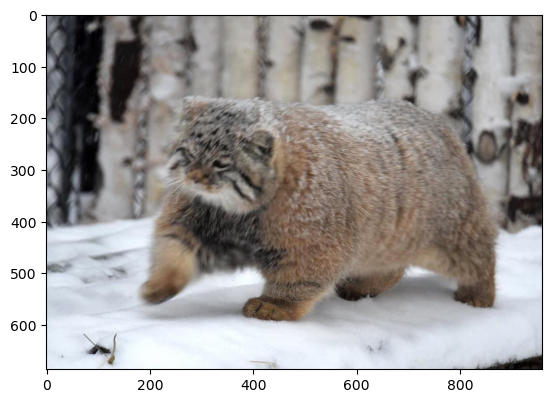

In [2]:
# 1. Define the model checkpoint name
model_checkpoint = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
vit = AutoModelForImageClassification.from_pretrained(model_checkpoint)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

In [3]:
inputs = image_processor(image, return_tensors="pt").to(vit.device)

with torch.no_grad():
  logits = vit(**inputs).logits
predicted_class_id = logits.argmax(dim=-1).item()

class_labels = vit.config.id2label
predicted_class_label = class_labels[predicted_class_id]
print(f"The predicted class label is: {predicted_class_label}")

The predicted class label is: lynx, catamount


## Adding CLT to model

### Single Layer Example

In [4]:
# Wrap your ViT
clt_model = CLTModel(vit)

# listing all CLT layers
clt_model.list_clt_layers()

['vit.encoder.layer.0.intermediate',
 'vit.encoder.layer.1.intermediate',
 'vit.encoder.layer.2.intermediate',
 'vit.encoder.layer.3.intermediate',
 'vit.encoder.layer.4.intermediate',
 'vit.encoder.layer.5.intermediate',
 'vit.encoder.layer.6.intermediate',
 'vit.encoder.layer.7.intermediate',
 'vit.encoder.layer.8.intermediate',
 'vit.encoder.layer.9.intermediate',
 'vit.encoder.layer.10.intermediate',
 'vit.encoder.layer.11.intermediate']

In [5]:
l1_name = "vit.encoder.layer.0.intermediate"
l2_name = "vit.encoder.layer.1.intermediate"

# Add CLT between MLP layers of consecutive blocks
clt = clt_model.add_clt(
    source_layer=l1_name,
    target_layer=l2_name, 
    hidden_dim=4096,
    k=64
)

# Forward pass collects activations
output = clt_model(**inputs)

# Get activations for training
source_act = clt_model.get_clt_activations(l1_name, "source")
target_act = clt_model.get_clt_activations(l1_name, "target")
features = clt_model.get_clt_activations(l1_name, "features")

# Train the CLT
clt_output, _, _ = clt(source_act, return_features=True)
loss, loss_dict = clt_loss(clt_output, target_act, features)

In [6]:
loss_dict

{'reconstruction': tensor(0.0712, grad_fn=<MseLossBackward0>),
 'l1_sparsity': tensor(0.0091),
 'total': tensor(0.0712, grad_fn=<AddBackward0>)}

## Full Traced Model

In [7]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from pathlib import Path
from PIL import Image

class ImageFolderDataset(Dataset):
    """Simple dataset for ImageNet-style folder structure."""
    
    def __init__(self, root_dir: str, processor):
        self.root_dir = Path(root_dir)
        self.processor = processor
        
        # Collect all image paths
        self.image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.JPEG', '*.png']:
            self.image_paths.extend(self.root_dir.rglob(ext))
        
        # tmp
        # self.image_paths = self.image_paths[:10]

        print(f"Found {len(self.image_paths)} images in {root_dir}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Process image using the ViT processor
        inputs = self.processor(image, return_tensors="pt")
        
        # Remove batch dimension (DataLoader will add it back)
        return inputs['pixel_values'].squeeze(0)


# Create datasets for train and val, then merge
train_dataset = ImageFolderDataset("data/train", image_processor)
val_dataset = ImageFolderDataset("data/val", image_processor)

# Merge into single dataset
full_dataset = ConcatDataset([train_dataset, val_dataset])
print(f"Total dataset size: {len(full_dataset)}")

# Create dataloader
dataloader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=0)

Found 69490 images in data/train
Found 7846 images in data/val
Total dataset size: 77336


In [ ]:
# Wrap your model in the CLT Class
clt_model = CLTModel(vit)

# Add CLT to all adjacent classes
clt_model.add_all_clts(hidden_dim=128, k=4)

# train it with the dataloader class
loss_history = clt_model.train_clts(dataloader, num_epochs=1)

Found 12 layers, creating 11 CLTs
ADDING Cross Layer Transcoders (CLT)
  Created CLT: vit.encoder.layer.0.intermediate -> vit.encoder.layer.1.intermediate
  Created CLT: vit.encoder.layer.1.intermediate -> vit.encoder.layer.2.intermediate
  Created CLT: vit.encoder.layer.2.intermediate -> vit.encoder.layer.3.intermediate
  Created CLT: vit.encoder.layer.3.intermediate -> vit.encoder.layer.4.intermediate
  Created CLT: vit.encoder.layer.4.intermediate -> vit.encoder.layer.5.intermediate
  Created CLT: vit.encoder.layer.5.intermediate -> vit.encoder.layer.6.intermediate
  Created CLT: vit.encoder.layer.6.intermediate -> vit.encoder.layer.7.intermediate
  Created CLT: vit.encoder.layer.7.intermediate -> vit.encoder.layer.8.intermediate
  Created CLT: vit.encoder.layer.8.intermediate -> vit.encoder.layer.9.intermediate
  Created CLT: vit.encoder.layer.9.intermediate -> vit.encoder.layer.10.intermediate
  Created CLT: vit.encoder.layer.10.intermediate -> vit.encoder.layer.11.intermediate

F

Epoch 1/1:  66%|██████▌   | 6404/9667 [1:36:07<54:04,  1.01it/s, loss=5.035951]  

Analyzed 20 samples across 11 layers
Saved figure to outputs/activations.png


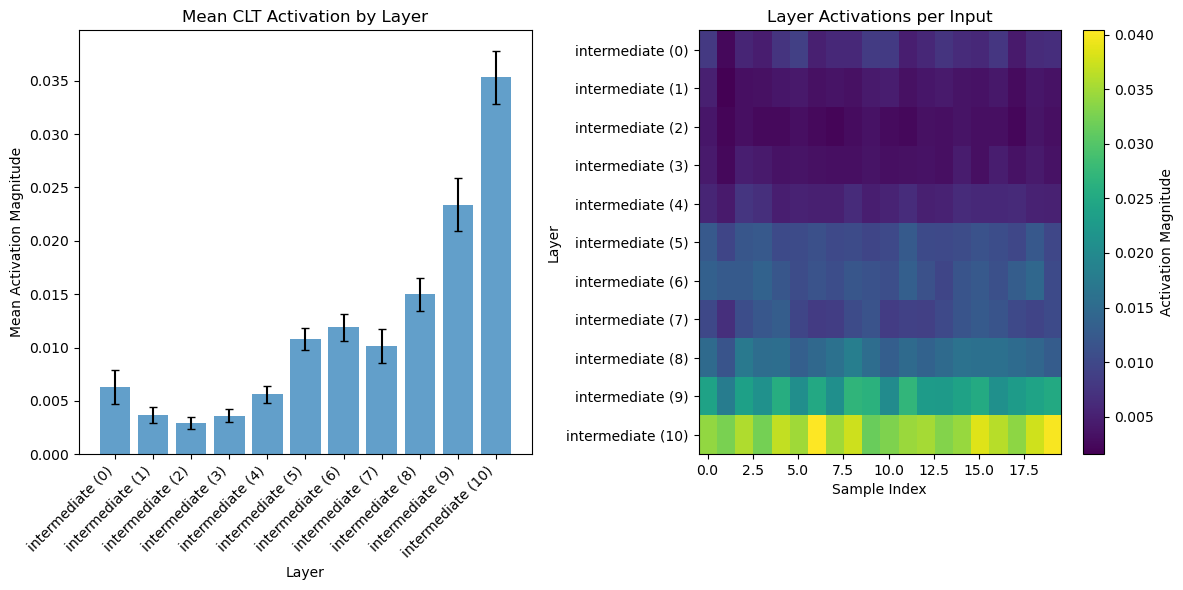

In [ ]:
result = clt_model.plot_layer_activation_histogram(dataloader, "outputs/activations.png")
peak_layers = result['peak_layers']

In [ ]:
# for index 0, the layer with the heighest activation
sample_idx = 0
layer = result['layer_names'][peak_layers[sample_idx]]
print(f"For index {sample_idx}, the max activation was observed at layer {layer}")

For index 0, the max activation was observed at layer vit.encoder.layer.10.intermediate
